In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.functional as F
from tqdm import trange
import scipy
import scipy.stats
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [2]:
expert_states  = torch.tensor(np.load("states_expert_Pendulum.npy"), dtype=torch.float)
expert_actions = torch.tensor(np.load("actions_expert_Pendulum.npy"), dtype=torch.float)

In [3]:
expert_states.shape, expert_actions.shape

(torch.Size([500, 200, 3]), torch.Size([500, 200, 1]))

In [4]:
env_name = "Pendulum-v1"
env = gym.make(env_name)
action_space_size = env.action_space.shape[0]
state_space_size  = env.observation_space.shape[0]
state_space_size, action_space_size

(3, 1)

In [5]:
# constants, parameters

# BC data param's
NUM_HUMAN_PTS = 25 # number of episodes
NUM_HUMAN_PTS2 = 5 # number of time points
# if this is <0, NUM_HUMAN_PTS2 is not used, should be 199*NUM_HUMAN_PTS

#NUM_HUMAN_PTS = 25 # number of episodes
#NUM_HUMAN_PTS2 = 5 # number of time points

# NN param's
NUM_TR_EPOCHS = 300
BATCH_SIZE = 256
LR = 0.0001
LOSS_FUNC = nn.MSELoss()
# things tried:
# NUM_TR_EPOCHS = 300 # overfits
# LOSS_FUNC = nn.L1Loss() # doesn't help
# LR = .001 # gets it so that BC reward > Expert reward !
# NUM_HUMAN_PTS = 100 # gets it so that BC reward > Expert reward !

N_PLOT_ACTION = 250 # for 3D viz.

NUM_ITERATIONS = 25
N_PLOT_EPISODES = 25
# things tried
# NUM_ITERATIONS = 6
# N_PLOT_EPISODES = 50

# saving
LOSS_PLOT_PREFIX_FNAME = 'loss_plot'
COMPARISON_PLOT_PREFIX_FNAME = 'compare_plot'

Sample a Dataset of expert behavior 

    (state (3,) -> action (1,)) or 
    (*state, action)(4,)

The data samples will be collected by taking NUM_HUMAN_PTS2 samples from NUM_HUMAN_PTS episodes of the expert behavior data. 

In [6]:
sampled_data = torch.concat([expert_states, expert_actions], 2)[:NUM_HUMAN_PTS, slice(None) if NUM_HUMAN_PTS2 <= 0 else slice(NUM_HUMAN_PTS2)]
sampled_data = sampled_data.reshape((-1, 4))
sampled_data = sampled_data[torch.randperm(sampled_data.shape[0])]
sampled_data.shape

torch.Size([125, 4])

In [7]:
training_samples = int(sampled_data.shape[0]*0.7)
training_set = sampled_data[:training_samples]
testing_set = sampled_data[training_samples:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

training_set torch.Size([87, 4])
testing_set torch.Size([38, 4])


In [8]:
bc_pendulum = nn.Sequential(
    nn.Linear(state_space_size, 40),
    nn.ReLU(),
    nn.Linear(40, 80),
    nn.ReLU(),
    nn.Linear(80, 120),
    nn.ReLU(),
    nn.Linear(120, 100),
    nn.ReLU(),
    nn.Linear(100, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, action_space_size)
)
criterion = LOSS_FUNC
learning_rate = LR
optimizer = torch.optim.Adam(bc_pendulum.parameters(), lr=learning_rate)

In [9]:
loss_list = []
test_loss = []
batch_size = BATCH_SIZE
num_batches = int(np.ceil(training_set.shape[0]/batch_size))
n_epoch = NUM_TR_EPOCHS

for itr in range(n_epoch):
    total_loss = 0
    for batch_i in range(num_batches):
        data = training_set[batch_i*batch_size: (batch_i+1)*batch_size]
        x      = data[:, :state_space_size]
        y      = data[:, state_space_size:]
        y_pred = bc_pendulum(x)
        loss   = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("[EPOCH]: %i, [MSE LOSS]: %.6f" % (itr+1, total_loss /num_batches))
    # display.clear_output(wait=True)
    loss_list.append(total_loss /num_batches)
    x      = testing_set[:, :state_space_size]
    y      = testing_set[:, state_space_size:]
    with torch.no_grad():
        y_pred = bc_pendulum(x)
    loss   = criterion(y_pred, y).item()
    test_loss.append(loss)
    

[EPOCH]: 1, [MSE LOSS]: 2.443542
[EPOCH]: 2, [MSE LOSS]: 2.442266
[EPOCH]: 3, [MSE LOSS]: 2.440971
[EPOCH]: 4, [MSE LOSS]: 2.439679
[EPOCH]: 5, [MSE LOSS]: 2.438410
[EPOCH]: 6, [MSE LOSS]: 2.437171
[EPOCH]: 7, [MSE LOSS]: 2.435971
[EPOCH]: 8, [MSE LOSS]: 2.434808
[EPOCH]: 9, [MSE LOSS]: 2.433661
[EPOCH]: 10, [MSE LOSS]: 2.432519
[EPOCH]: 11, [MSE LOSS]: 2.431387
[EPOCH]: 12, [MSE LOSS]: 2.430271
[EPOCH]: 13, [MSE LOSS]: 2.429179
[EPOCH]: 14, [MSE LOSS]: 2.428121
[EPOCH]: 15, [MSE LOSS]: 2.427111
[EPOCH]: 16, [MSE LOSS]: 2.426108
[EPOCH]: 17, [MSE LOSS]: 2.425105
[EPOCH]: 18, [MSE LOSS]: 2.424118
[EPOCH]: 19, [MSE LOSS]: 2.423114
[EPOCH]: 20, [MSE LOSS]: 2.422098
[EPOCH]: 21, [MSE LOSS]: 2.421084
[EPOCH]: 22, [MSE LOSS]: 2.420065
[EPOCH]: 23, [MSE LOSS]: 2.419033
[EPOCH]: 24, [MSE LOSS]: 2.417995
[EPOCH]: 25, [MSE LOSS]: 2.416951
[EPOCH]: 26, [MSE LOSS]: 2.415900
[EPOCH]: 27, [MSE LOSS]: 2.414829
[EPOCH]: 28, [MSE LOSS]: 2.413741
[EPOCH]: 29, [MSE LOSS]: 2.412635
[EPOCH]: 30, [MSE LOSS]

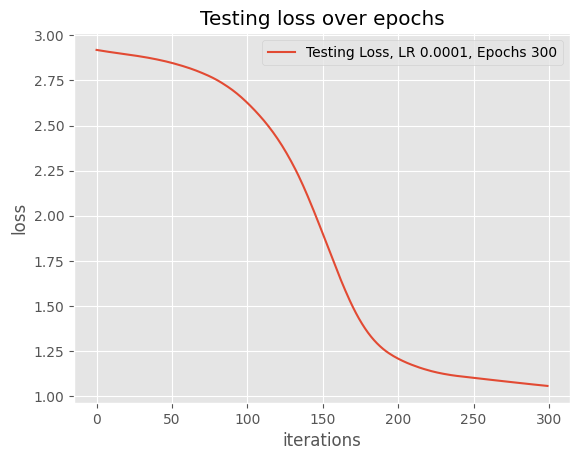

In [10]:
plt.plot(test_loss, label=f'Testing Loss, LR {LR}, Epochs {n_epoch}')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Testing loss over epochs")
plt.legend()
plt.savefig(f"{LOSS_PLOT_PREFIX_FNAME}_lr{LR}.png")

In [11]:
def plot_pendulum(ax, state, action, color='red'):
    x, y = state[:, 0], state[:, 1]
    z = action
    ax.scatter(x, y, z, color=color)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Action')

    # Show the plot
    return ax

In [12]:
y_pred.shape

torch.Size([38, 1])

<Axes3D: xlabel='X', ylabel='Y', zlabel='Action'>

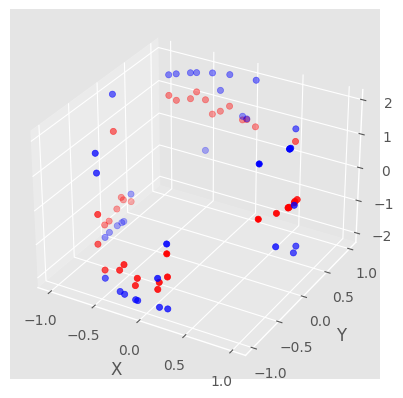

In [13]:
ax = plt.subplot(111, projection='3d')
plot_pendulum(ax, x[:N_PLOT_ACTION], y[:N_PLOT_ACTION, 0], color='blue')
plot_pendulum(ax, x[:N_PLOT_ACTION], y_pred[:N_PLOT_ACTION, 0])


### Render game play

In [14]:
# enviz = gym.make(env_name, render_mode='human')

In [15]:
# state = enviz.reset()[0]
# terminateed = False
# truncated = False
# reward = 0
# while not terminateed and not truncated:
#     action = bc_pendulum(torch.from_numpy(state)).detach().clip(-2, 2).item()
#     state, r, terminateed, truncated, _ = enviz.step([action])
#     reward += r
    
    
# print(f"Terminated: {terminateed}")
# print(f"Truncated: {truncated}")
# print(f"Reward: {reward}")

In [16]:
# enviz.close()

### Test in simulation

In [18]:
n_iterations = NUM_ITERATIONS
n_ep = N_PLOT_EPISODES
max_steps = 500
gamma = 1.0
# seeds = [684, 559, 629, 192, 835] # random seeds for testing
seeds = np.random.randint(-10000, 10000, size=NUM_ITERATIONS)

seed_reward_mean =[]
seed_reward = []

for itr in trange(n_iterations):
    G = []
    G_mean = []
    for ep in range(n_ep):
        state = env.reset()[0]
        reward = 0
        for step in range(max_steps):
            action = bc_pendulum(torch.from_numpy(state)).detach().clip(-2,2).tolist()
            # action = np.clip(action.detach().numpy(), -2, 2).tolist()
            # print(f"attempting action {action}")
            state, r, terminateed, truncated, _ = env.step(action)
            reward += r*gamma**step
        G.append(reward)
        G_mean.append(np.mean(G))
    seed_reward.append(G)
    seed_reward_mean.append(G_mean)

seed_reward_mean_bc = np.array(seed_reward_mean)
    

100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


In [19]:
seed_reward_mean_bc = np.array(seed_reward_mean)
mean_bc = np.mean(seed_reward_mean_bc, 0)
std_bc = np.std(seed_reward_mean_bc, 0)

In [20]:
# expert
expert  = np.load("reward_mean_pendulum_expert.npy")
mean_expert= np.mean(expert,axis=0)
std_expert = np.std(expert,axis=0)

# subset to same length as sim. above
mean_expert = mean_expert[:N_PLOT_EPISODES]
std_expert = std_expert[:N_PLOT_EPISODES]

In [21]:
# random
random_mean  = np.load("reward_mean_pendulum_random.npy")
mean_random= np.mean(random_mean,axis=0)
std_random  = np.std(random_mean,axis=0)

# subset to same length as sim. above
mean_random = mean_random[:N_PLOT_EPISODES]
std_random = std_random[:N_PLOT_EPISODES]

In [22]:
expert.shape, random_mean.shape, seed_reward_mean_bc.shape

((5, 1000), (5, 1000), (25, 25))

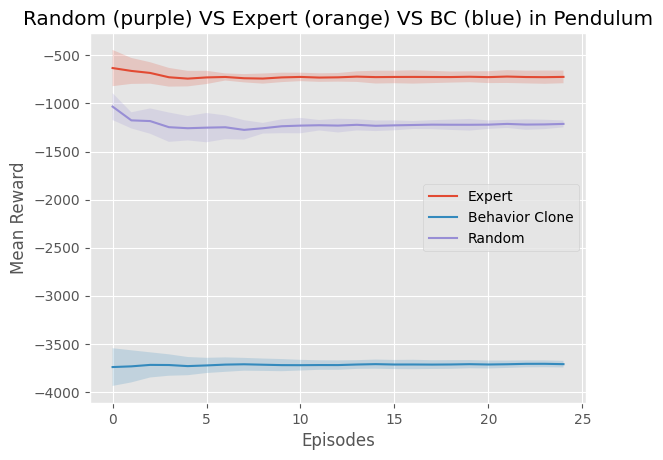

In [23]:
x = np.arange(N_PLOT_EPISODES)

def add_to_plot(mean, std, lable):
    plt.plot(x, mean, "-", label=lable)
    plt.fill_between(x, mean+std, mean-std, alpha=0.2)

add_to_plot(mean_expert, std_expert, "Expert")
add_to_plot(mean_bc, std_bc, "Behavior Clone")
add_to_plot(mean_random, std_random, "Random")

plt.xlabel("Episodes") 
plt.ylabel("Mean Reward") 
plt.title("Random (purple) VS Expert (orange) VS BC (blue) in Pendulum") 
plt.legend()


In [24]:


def t_test(x1, s1, n1, x2, s2, n2):
    return (x1-x2)/np.sqrt((s1**2/n1)+(s2**2/n2))

def pval(x1, s1, n1, x2, s2, n2):
    t = t_test(x1, s1, n1, x2, s2, n2)
    return (scipy.stats.t.sf(abs(t), n1+n2-1)*2).item()


num_expert_samples = expert.shape[0]
num_random_samples = random_mean.shape[0]

expert_bc_different_distributions = pval(mean_expert[-20], std_expert[-20], num_expert_samples, mean_bc[-20], std_bc[-20], n_iterations) < 0.05
random_bc_different_distributions = pval(mean_random[-20], std_random[-20], num_random_samples, mean_bc[-20], std_bc[-20], n_iterations) < 0.05

expert_bc_different_distributions, random_bc_different_distributions

(True, True)